In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Model
import cv2
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import VGG16, ResNet50V2
plt.style.use('default')

In [5]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [6]:
import os
def plot_imgs(directory, top=10):
    all_item_dirs = os.listdir(directory)
    item_files = [os.path.join(directory, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize=(20, 20))
  
    for i, img_path in enumerate(item_files):
        plt.subplot(10, 10, i+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

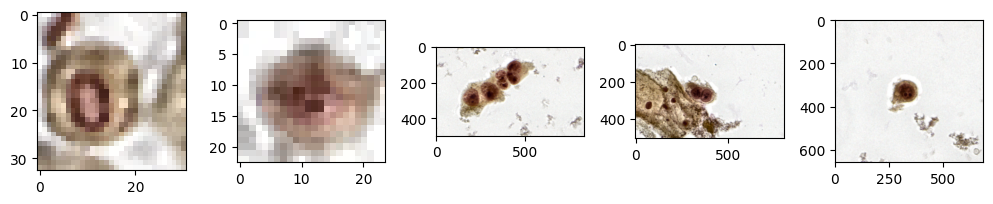

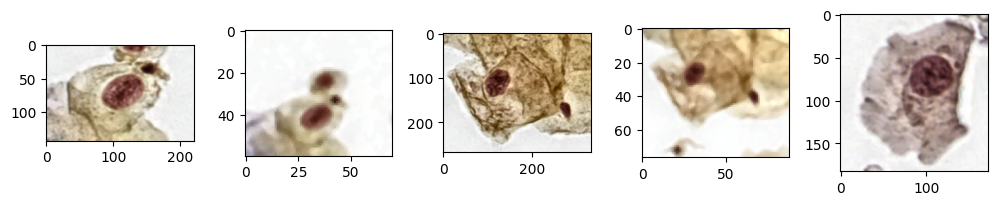

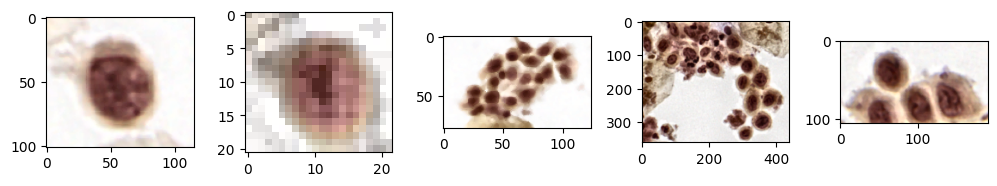

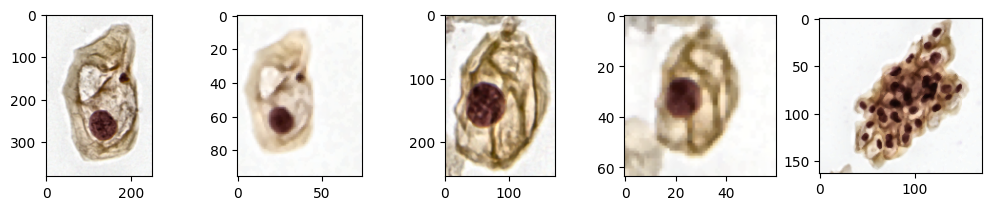

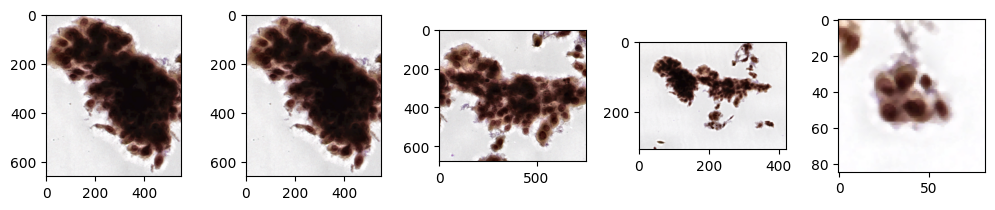

In [7]:
data_path = 'DataProcessed/train/'

directories = ['ASC_H','ASC_US','HSIL','LSIL','SCC'] 

for j in directories:
    plot_imgs(data_path+j)

In [8]:
# def clahe_filter(image):
#     imageRead = cv2.imread(image)
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     # Apply median filter
#     image_median = cv2.medianBlur(imageRead, 3)  # Adjust the kernel size as needed
    
#     # Apply CLAHE filter to the median filtered image
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(56, 56))
#     lab = cv2.cvtColor(image_median, cv2.COLOR_RGB2LAB)
#     lab_planes = cv2.split(lab)
#     lab_planes_list = list(lab_planes)
#     lab_planes_list[0] = clahe.apply(lab_planes_list[0])
#     lab = cv2.merge(lab_planes_list)
#     filtered_image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
#     return filtered_image

In [9]:
batch_size = 16
train_datagen = ImageDataGenerator(#horizontal_flip = True, 
                                  rescale = 1./255, 
                                  # zoom_range = 0.2,
                                  validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
Categories=['ASC_H','ASC_US','HSIL','LSIL','SCC'] 
train_data_path = 'DataProcessed/train/'
test_data_path = 'DataProcessed/test/'

train_set = train_datagen.flow_from_directory(train_data_path, target_size = (112,112),
                                              batch_size = batch_size, 
                                              #color_mode = 'rgba',
                                              class_mode = 'categorical',
                                             subset='training',
                                             shuffle="True")

valid_set = train_datagen.flow_from_directory(train_data_path, target_size = (112,112),
                                              batch_size = batch_size, 
                                              #color_mode = 'rgba',
                                              class_mode = 'categorical',
                                             subset='validation',
                                             shuffle="True")

test_set = test_datagen.flow_from_directory(test_data_path, target_size = (112,112),
                                              batch_size = batch_size, 
                                              #color_mode = 'rgba',
                                              class_mode = 'categorical')

Found 13597 images belonging to 5 classes.
Found 1508 images belonging to 5 classes.
Found 712 images belonging to 5 classes.


In [11]:
classes = 5

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(112, 112, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)

# x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
# x = BatchNormalization()(x)
# predictions = Dense(train_generator.num_classes, activation='softmax')(x)
predictions = Dense(classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'conv4_block1_preact_bn':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
print(model.summary())

94668760/94668760 [==============================] - 10s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 56, 56, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)  

In [12]:
# import keras
# optimizer1 = keras.optimizers.Adam(learning_rate=0.001)
base_learning_rate = 0.0001
model.compile(loss = 'categorical_crossentropy',optimizer = RMSprop(learning_rate=base_learning_rate) , metrics = ['accuracy'])

In [13]:
model_path="saved_models/ResNet50V2Pre.h5"
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2, min_lr=1e-6)
checkpoint = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, 
                              save_best_only=True, mode='max')

callbacks_list = [checkpoint, reduce_lr]

In [14]:
num_epochs = 15
training_steps=train_set.n//train_set.batch_size
validation_steps =test_set.n//test_set.batch_size

In [15]:
history = model.fit(train_set, epochs=num_epochs, steps_per_epoch=training_steps,validation_data=valid_set,
                    validation_steps=validation_steps, callbacks = callbacks_list)

Epoch 1/15
849/849 [==============================] - ETA: 0s - loss: 1.4507 - accuracy: 0.3855
Epoch 1: accuracy improved from -inf to 0.38546, saving model to saved_models\ResNet50V2Pre.h5
849/849 [==============================] - 125s 119ms/step - loss: 1.4507 - accuracy: 0.3855 - val_loss: 1.3343 - val_accuracy: 0.4347 - lr: 1.0000e-04
Epoch 2/15
849/849 [==============================] - ETA: 0s - loss: 1.1888 - accuracy: 0.4737
Epoch 2: accuracy improved from 0.38546 to 0.47368, saving model to saved_models\ResNet50V2Pre.h5
849/849 [==============================] - 98s 116ms/step - loss: 1.1888 - accuracy: 0.4737 - val_loss: 1.1441 - val_accuracy: 0.4929 - lr: 1.0000e-04
Epoch 3/15
849/849 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.5240
Epoch 3: accuracy improved from 0.47368 to 0.52397, saving model to saved_models\ResNet50V2Pre.h5
849/849 [==============================] - 98s 115ms/step - loss: 1.0986 - accuracy: 0.5240 - val_loss: 1.5907 - val_a

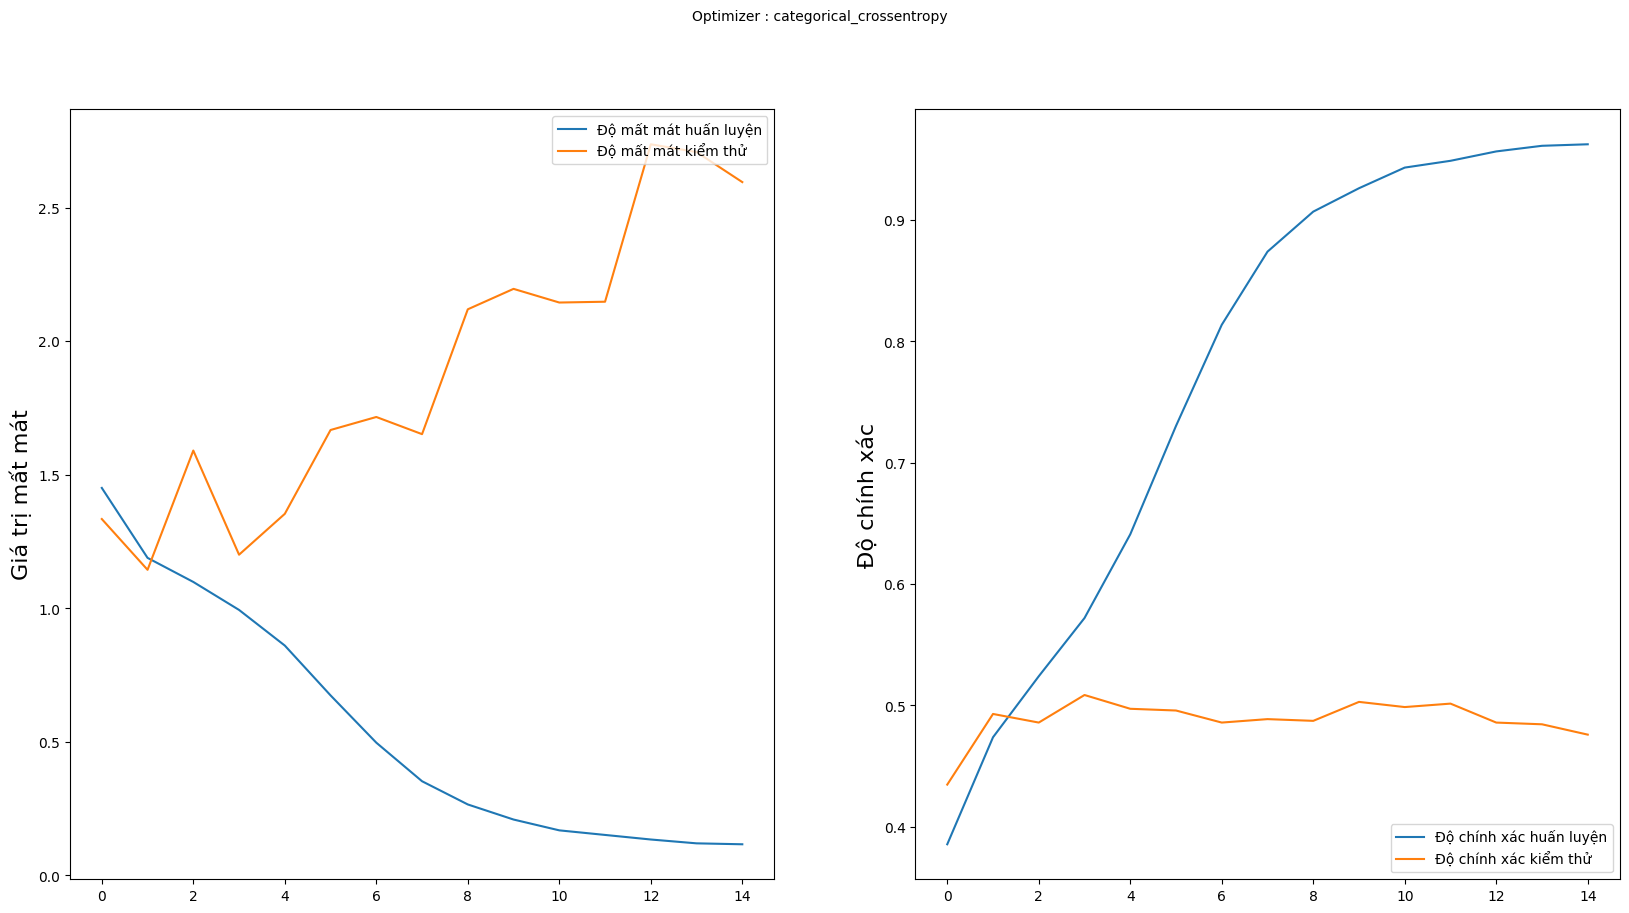

In [16]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : categorical_crossentropy', fontsize=10)
plt.ylabel('Giá trị mất mát', fontsize=16)
plt.plot(history.history['loss'], label='Độ mất mát huấn luyện')
plt.plot(history.history['val_loss'], label='Độ mất mát kiểm thử')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.ylabel('Độ chính xác', fontsize=16)
plt.plot(history.history['accuracy'], label='Độ chính xác huấn luyện')
plt.plot(history.history['val_accuracy'], label='Độ chính xác kiểm thử')
plt.legend(loc='lower right')
plt.show()

45/45 [==============================] - 3s 73ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

       ASC_H       0.23      0.22      0.23       168
      ASC_US       0.23      0.20      0.21       152
        HSIL       0.23      0.19      0.21       128
        LSIL       0.18      0.20      0.19       136
         SCC       0.16      0.22      0.19       128

    accuracy                           0.21       712
   macro avg       0.21      0.20      0.20       712
weighted avg       0.21      0.21      0.21       712



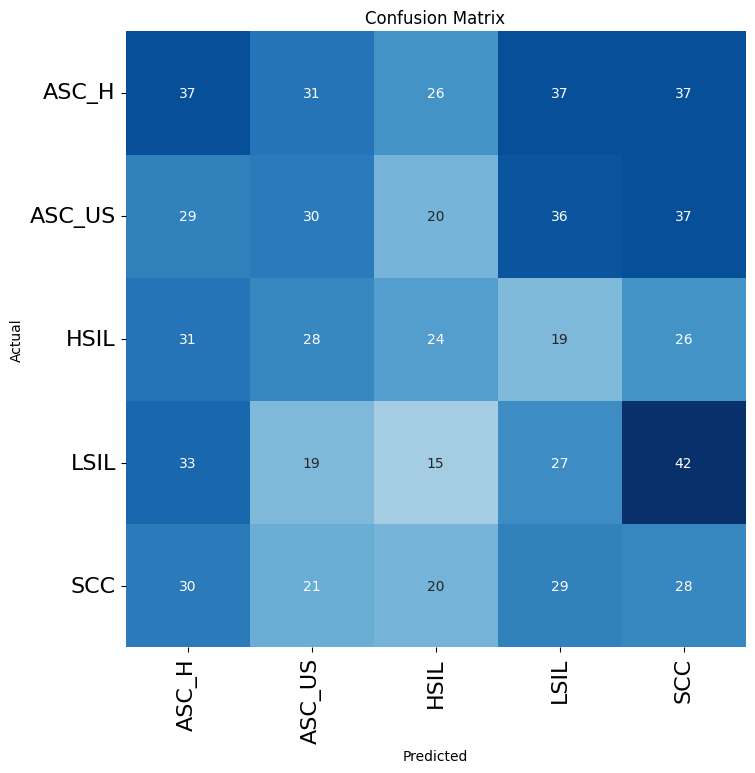

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

def cm_cr(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys()) # ordered lst of class names 
    pred_list=[ ] # will store the predicted classes here
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

cm_cr(test_set, model)

45/45 [==============================] - 3s 67ms/step


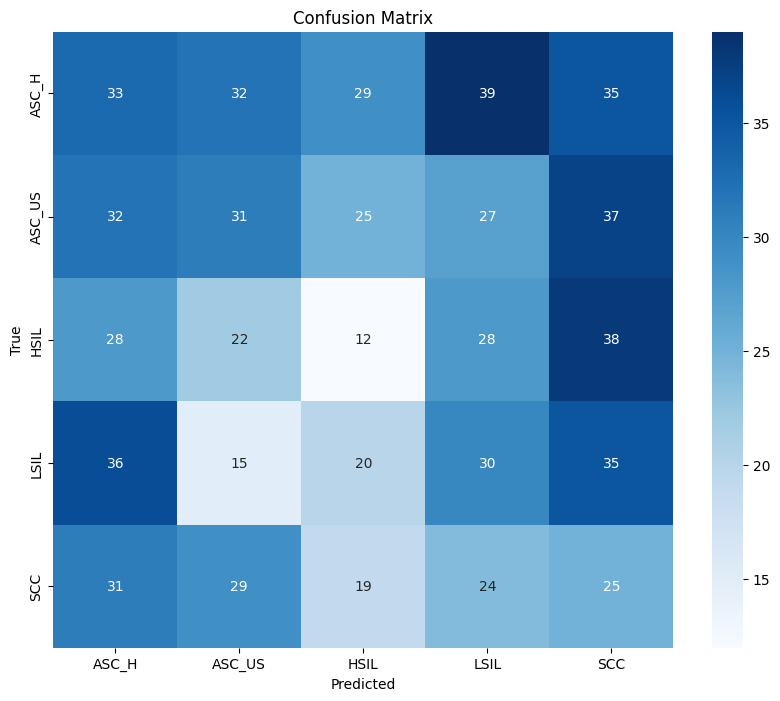

    Class  Precision    Recall  F1 Score
0   ASC_H   0.206250  0.196429  0.201220
1  ASC_US   0.240310  0.203947  0.220641
2    HSIL   0.114286  0.093750  0.103004
3    LSIL   0.202703  0.220588  0.211268
4     SCC   0.147059  0.195312  0.167785


In [24]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Make Predictions
y_pred = model.predict(test_set)

# Convert Predictions and True Labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_set.classes

# Create the Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)


# Create a dictionary to map class indices to class names
class_indices = test_set.class_indices
class_names = {v: k for k, v in class_indices.items()}


# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices,
            yticklabels=test_set.class_indices)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Create a list of class names
class_names_list = [class_names[i] for i in range(len(class_indices))]

# Create a DataFrame to organize the results
results_df = pd.DataFrame({
    'Class': class_names_list,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Print the results table
print(results_df)
